# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
#!mkdir cifar10
#!curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvzf cifar-10-python.tar.gz -C cifar10

In [12]:
import numpy as np
#import matplotlib.pyplot as plt

#%matplotlib inline

In [13]:
from cifar import load_CIFAR10
#plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_val = X_test
y_val = y_test

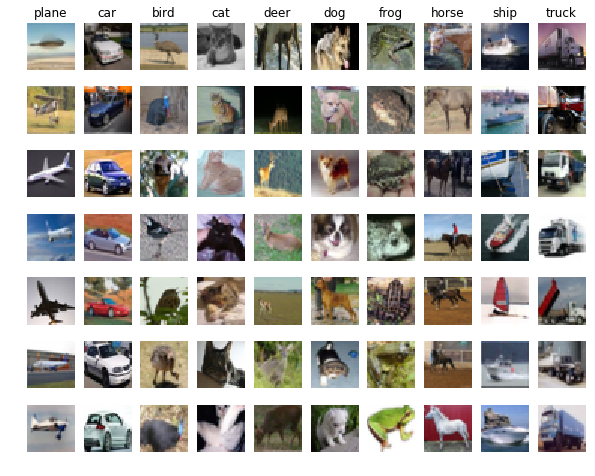

In [4]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Глубиной. Там было 4-9 слоев потом где-то 18, а сейчас уже намного больше

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Не получается хорошо посчитать градиент из-за размера, локальных минимумов так же больше

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить?

Легко переобучиться, если не использовать свертки то сеть может выродиться в наблюдение за одним пикселем.
Что можно сделать: во первых увеличить датасет с помощью разных преобразований картинок. Можно менять освещение форму, положение и т. д.. Потом использовать сверточные слои

**Вопрос 4**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?



**Вопрос 5**: Как сделать стайл трансфер для музыки? oO

Разложить в спектр преобразовать как картинку, или как-то по-другому. Нормально сейчас это вроде не умеют делать

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- http://www.robots.ox.ac.uk/~vgg/research/very_deep/
- https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Wish you get fun :)

In [1]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *
from lasagne import init

input_X = T.tensor4("X", dtype='float32')
target_y = T.vector("target Y integer",dtype='int32')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN not available)


In [2]:
import lasagne.layers as ll
import lasagne.nonlinearities as lnl

def add_dense_tail(net, N):
    flag = True
    while N > 10:
        net = ll.DenseLayer(net, num_units=500, nonlinearity=
                            (lnl.sigmoid if flag else lnl.rectify))
        flag ^= True
        if N >= 100:
            net = lasagne.layers.DropoutLayer(net, 0.5)
        N /= 10
        
    return ll.DenseLayer(net,num_units = 10, nonlinearity=softmax)

net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

net = lasagne.layers.Conv2DLayer(net, 10, 2, pad='valid', nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(gain='relu'))

net = lasagne.layers.Conv2DLayer(net, 25, 4, pad='valid', nonlinearity=lasagne.nonlinearities.sigmoid)

net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2))

net1 = add_dense_tail(net, 100)

net = lasagne.layers.Conv2DLayer(net, 1000, 5, pad='valid', nonlinearity=lasagne.nonlinearities.rectify)

net = add_dense_tail(net, 1000)

In [3]:
import lasagne.layers as ll
import lasagne.nonlinearities as lnl

def add_dense_tail(net, N):
    flag = True
    while N > 10:
        net = ll.DenseLayer(net, num_units=500, nonlinearity=lnl.leaky_rectify)
        flag ^= True
        if N >= 100:
            net = ll.DropoutLayer(net, 0.5)
        N /= 10
        
    return ll.DenseLayer(net,num_units = 10, nonlinearity=softmax)

net = ll.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

net = ll.batch_norm(ll.Conv2DLayer(net, 64, 3, pad=1, nonlinearity=lnl.leaky_rectify))

net = ll.MaxPool2DLayer(net, pool_size=(2, 2), stride=2)

net = ll.batch_norm(ll.Conv2DLayer(net, 128, 4, pad=1, nonlinearity=lnl.leaky_rectify))

net = ll.DropoutLayer(net, 0.5)
net = ll.MaxPool2DLayer(net, pool_size=(2, 2), stride=2)

net = ll.batch_norm(ll.Conv2DLayer(net, 256, 3, pad=1, nonlinearity=lnl.leaky_rectify))

net = ll.DropoutLayer(net, 0.5)

net0 = add_dense_tail(net, 100)

net = ll.DenseLayer(net,num_units = 800, nonlinearity=lnl.leaky_rectify)

net = ll.DropoutLayer(net, 0.5)

net = ll.DenseLayer(net,num_units = 800, nonlinearity=lnl.leaky_rectify)

net = ll.DropoutLayer(net, 0.5)

net1 = add_dense_tail(net, 100)

net = ll.DenseLayer(net,num_units = 800, nonlinearity=lnl.leaky_rectify)

net = ll.DropoutLayer(net, 0.5)

net = ll.DenseLayer(net,num_units = 800, nonlinearity=lnl.leaky_rectify)

net = ll.DropoutLayer(net, 0.5)

net2 = add_dense_tail(net, 400)


In [4]:
def pred_and_weight(net):
    return lasagne.layers.get_output(net), lasagne.layers.get_all_params(net, trainable=True)

y_predicted0, all_weights0 = pred_and_weight(net0)
y_predicted1, all_weights1 = pred_and_weight(net1)
y_predicted2, all_weights2 = pred_and_weight(net2)

print all_weights0
print all_weights1
print all_weights2

[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b, W, b]
[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b, W, b, W, b, W, b]
[W, beta, gamma, W, beta, gamma, W, beta, gamma, W, b, W, b, W, b, W, b, W, b, W, b, W, b]


In [5]:
def loss_and_acc(y_predicted):
    return lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean(), \
           lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean() 
    
loss0, accuracy0 = loss_and_acc(y_predicted0)
loss1, accuracy1 = loss_and_acc(y_predicted1)
loss2, accuracy2 = loss_and_acc(y_predicted2)

In [6]:
#updates = lasagne.updates.momentum(loss, all_weights, learning_rate=0.005, momentum=0.9)
#train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
#accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

In [8]:
def upd_train_accfun(loss, all_weights, accuracy):
    updates = lasagne.updates.adam(loss, all_weights, learning_rate=0.001)
    return \
        updates, \
        theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True), \
        theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

updates0, train_fun0, accuracy_fun0 = upd_train_accfun(loss0, all_weights0, accuracy0)
updates1, train_fun1, accuracy_fun1 = upd_train_accfun(loss1, all_weights1, accuracy1)
updates2, train_fun2, accuracy_fun2 = upd_train_accfun(loss2, all_weights2, accuracy2)

### Вот и всё, пошли её учить

In [10]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [ ]:
import time

num_epochs0 = 2
num_epochs1 = 2
num_epochs2 = 1000 #количество проходов по данным

def learn_epoch(epoch, train_fun, accuracy_fun):
    batch_size = 50 #размер мини-батча
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        # print("F",train_err_batch, train_acc_batch)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs2, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    

for epoch in range(-num_epochs0 - num_epochs1, -num_epochs1):
    learn_epoch(epoch, train_fun0, accuracy_fun0)
    
for epoch in range(-num_epochs1, 0):
    learn_epoch(epoch, train_fun1, accuracy_fun1)
    
for epoch in range(num_epochs2):
    learn_epoch(epoch, train_fun2, accuracy_fun2)

Epoch -3 of 1000 took 98.765s
  training loss (in-iteration):		1.250658
  train accuracy:		56.13 %
  validation accuracy:		60.15 %
Epoch -2 of 1000 took 98.708s
  training loss (in-iteration):		1.068747
  train accuracy:		62.83 %
  validation accuracy:		64.75 %
Epoch -1 of 1000 took 103.098s
  training loss (in-iteration):		1.218074
  train accuracy:		58.61 %
  validation accuracy:		65.85 %
Epoch 0 of 1000 took 103.182s
  training loss (in-iteration):		0.957389
  train accuracy:		68.05 %
  validation accuracy:		68.34 %
Epoch 1 of 1000 took 105.607s
  training loss (in-iteration):		1.068256
  train accuracy:		66.11 %
  validation accuracy:		66.78 %
Epoch 2 of 1000 took 105.589s
  training loss (in-iteration):		0.902306
  train accuracy:		71.75 %
  validation accuracy:		70.35 %
Epoch 3 of 1000 took 105.738s
  training loss (in-iteration):		0.844430
  train accuracy:		73.90 %
  validation accuracy:		71.18 %
Epoch 4 of 1000 took 105.768s
  training loss (in-iteration):		0.805530
  train ac

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 80:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Последнюю ячейку не запускал, так как ячейку обучения всегда прерывал - никогда не понятно на какой эпохе перестанет улучшаться результат.
Итого 75.02 accuracy

## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 